# Описание датасета

## Общая информация
Датасет содержит данные о прокате велосипедов в системе совместного использования

## Структура данных

### Основные поля

| Поле | Тип | Описание |
|------|-----|----------|
| `instant` | integer | Уникальный индекс записи |
| `dteday` | date | Дата (гггг-мм-дд) |
| `season` | integer | Сезон: 1-весна, 2-лето, 3-осень, 4-зима |
| `yr` | integer | Год: 0-2011, 1-2012 |
| `mnth` | integer | Месяц: от 1 до 12 |
| `hr` | integer | Час: от 0 до 23 (только в hour.csv) |
| `holiday` | integer | Праздничный день: 1-праздник, 0-не праздник |
| `weekday` | integer | День недели: от 0 до 6 |
| `workingday` | integer | Рабочий день: 1-если не выходной и не праздник, иначе 0 |
| `weathersit` | integer | Погодные условия: |

### Детализация погодных условий (`weathersit`)

| Код | Описание |
|-----|----------|
| 1 | Ясно, мало облаков, переменная облачность |
| 2 | Туман + облачно, туман + разорванные облака, туман + мало облаков |
| 3 | Небольшой снег, небольшой дождь + гроза + рассеянные облака, небольшой дождь + рассеянные облака |
| 4 | Сильный дождь + ледяная крупа + гроза + туман, снег + туман |

### Метеорологические данные (нормализованные)

| Поле | Описание | Диапазон |
|------|----------|----------|
| `temp` | Нормализованная температура в °C: (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 | [0, 1] |
| `atemp` | Нормализованная ощущаемая температура в °C: (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 | [0, 1] |
| `hum` | Нормализованная влажность: значения разделены на 100 (максимум) | [0, 1] |
| `windspeed` | Нормализованная скорость ветра: значения разделены на 67 (максимум) | [0, 1] |

### Целевые переменные

| Поле | Описание |
|------|----------|
| `casual` | Количество незарегистрированных (временных) пользователей |
| `registered` | Количество зарегистрированных пользователей |
| `cnt` | Общее количество арендованных велосипедов (casual + registered) |

## Особенности данных

- **Временной период**: 2011-2012 годы
- **Гранулярность**: Почасовые и дневные данные
- **Нормализация**: Метеорологические данные нормализованы к диапазону [0, 1]
- **Сезонность**: Учет сезонных изменений и погодных условий

## Использование для прогнозирования

Датасет подходит для задач:
- Прогнозирования спроса на прокат велосипедов
- Анализа влияния погодных условий на спрос
- Изучения сезонных паттернов использования
- Сравнения поведения зарегистрированных и временных пользователей

## Наша задача
- Прогнозирования спроса на прокат велосипедов

#Этап 1. Выгрузка данных + EDA

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("marklvl/bike-sharing-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bike-sharing-dataset' dataset.
Path to dataset files: /kaggle/input/bike-sharing-dataset


In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# files = []

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         filepath = os.path.join(dirname, filename)
#         print(filepath)
#         files.append(filepath.split('/'))

# mn_len = min(map(len, files))
# path = []
# for i in range(mn_len):
#     if all(files[0][i] == files[j][i] for j in range(len(files))):
#         path.append(files[0][i])
#     else:
#         break
# path_to_dataset = '/'.join(path)
# print(path_to_dataset)

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install pyod category_encoders shap lime catboost

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

from scipy import stats
from pyod.models.iforest import IForest
import category_encoders as ce
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool

from sklearn.feature_selection import f_classif, chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [5]:
df = pd.read_csv(os.path.join(path, "hour.csv"))
df.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [6]:
df.describe()

instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

In [7]:
def plot_box(df, column,
             ax=None,
             figsize=(8, 6),
             title=None,
             xlabel=None,
             ylabel=None,
             dropna=True,
             palette=None):

    flier_size = 5

    if column not in df.columns:
        raise ValueError(f"Колонка '{column}' отсутствует в DataFrame.")

    series = df[column].dropna() if dropna else df[column]
    if series.empty:
        raise ValueError(f"После удаления пропусков колонка '{column}' пуста.")

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    sb.boxplot(
        y=series,
        ax=ax,
        showfliers=True,
        fliersize=flier_size,
        palette=palette
    )

    if title:
        ax.set_title(title)
    ax.set_xlabel(xlabel if xlabel else "")
    ax.set_ylabel(ylabel if ylabel else column)

    ax.yaxis.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt
import seaborn as sb

def plot_hist(df, column,
              ax=None,
              figsize=(8, 6),
              title=None,
              xlabel=None,
              ylabel=None,
              dropna=True,
              bins=30,
              meanline=True,
              medline=True,
              midline=False,
              mx=None,
              mn=None):

    if column not in df.columns:
        raise ValueError(f"Колонка '{column}' отсутствует.")

    series = df[column].dropna() if dropna else df[column]
    if series.empty:
        raise ValueError(f"После удаления пропусков колонка '{column}' пуста.")

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.hist(series, bins=bins)

    if meanline:
        mean_val = series.mean()
        ax.axvline(mean_val, color='red', linewidth=2, label=f"Mean = {mean_val:.2f}")

    if medline:
        med_val = series.median()
        ax.axvline(med_val, color='black', linewidth=2, label=f"Median = {med_val:.2f}")

    if midline:
        if mx is None:
            mx = series.max()
        if mn is None:
            mn = series.min()
        mid_val = (mx + mn) / 2
        ax.axvline(mid_val, color='red', linewidth=1.5, linestyle='--',
                   alpha=0.5, label=f"Mid = {mid_val:.2f}")

    if title:
        ax.set_title(title)
    ax.set_xlabel(xlabel if xlabel else column)
    ax.set_ylabel(ylabel if ylabel else "Count")

    ax.legend()

    plt.tight_layout()
    plt.show()



def plot_scatter(df, x, y,
                 ax=None,
                 figsize=(8, 6),
                 title=None,
                 xlabel=None,
                 ylabel=None,
                 dropna=True):

    if x not in df.columns or y not in df.columns:
        raise ValueError("Обе колонки должны быть в DataFrame.")

    data = df[[x, y]].dropna() if dropna else df[[x, y]]

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(data[x], data[y], s=10)

    if title:
        ax.set_title(title)
    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)

    plt.tight_layout()
    plt.show()


def plot_line(df, x, y,
              ax=None,
              figsize=(10, 5),
              title=None,
              xlabel=None,
              ylabel=None,
              dropna=True,
              xticks=None,
              xtick_rotation=0,
              xgrid=False):
    if x not in df.columns or y not in df.columns:
        raise ValueError("Обе колонки должны быть в DataFrame.")

    data = df[[x, y]].dropna() if dropna else df[[x, y]]

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.plot(data[x], data[y])

    if xticks is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks, rotation=xtick_rotation)

    if xgrid:
        ax.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.7)

    if title:
        ax.set_title(title)

    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)

    plt.tight_layout()
    plt.show()

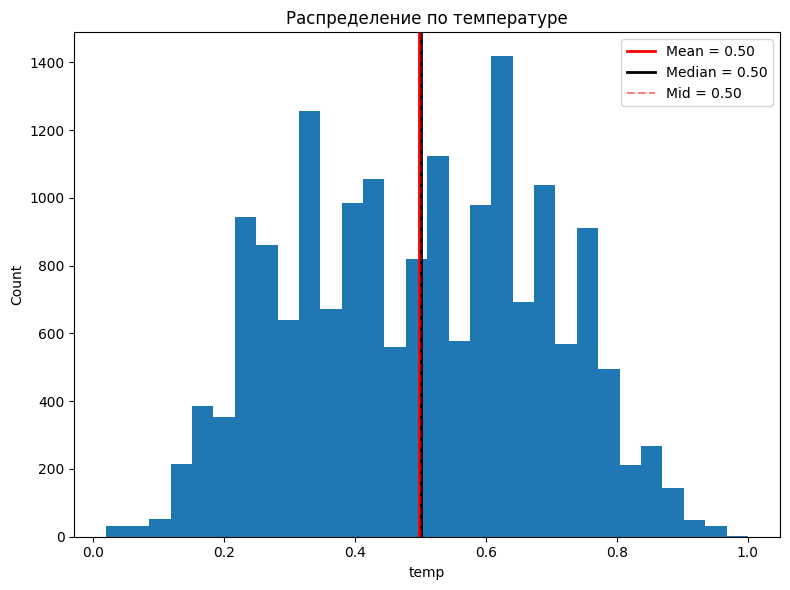

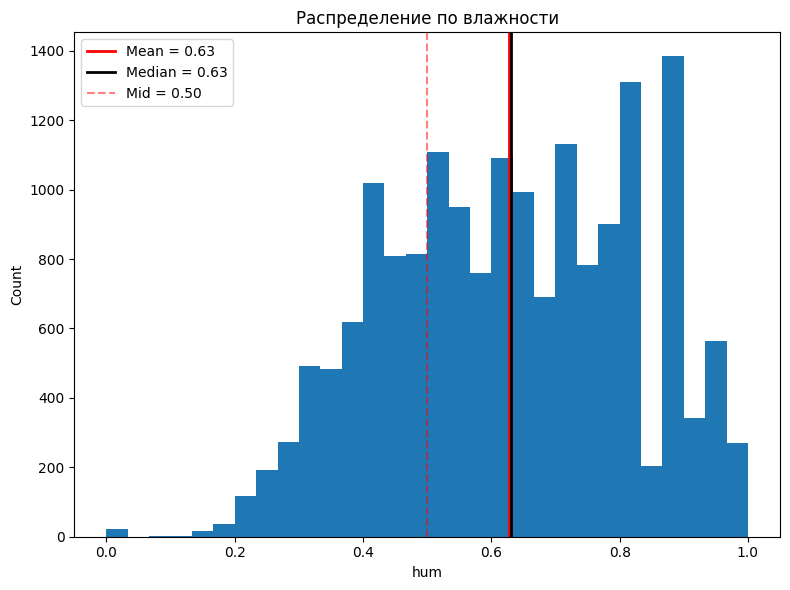

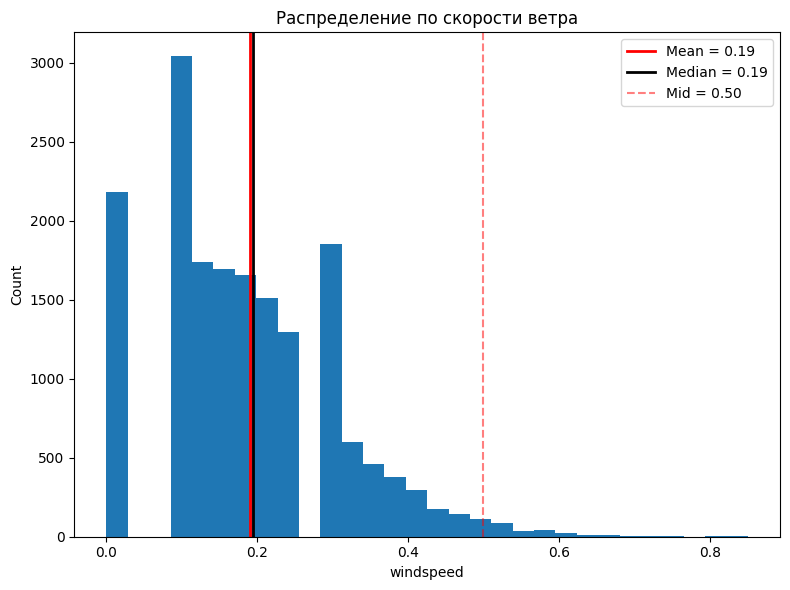

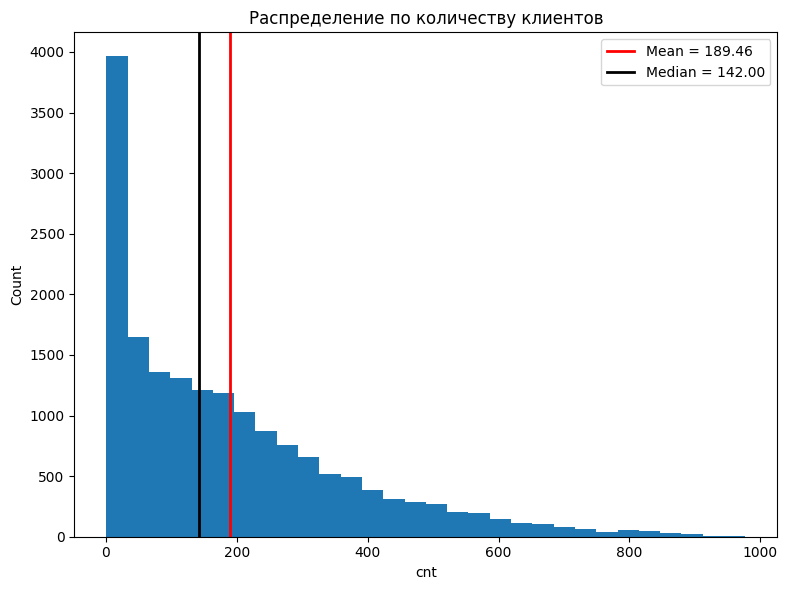

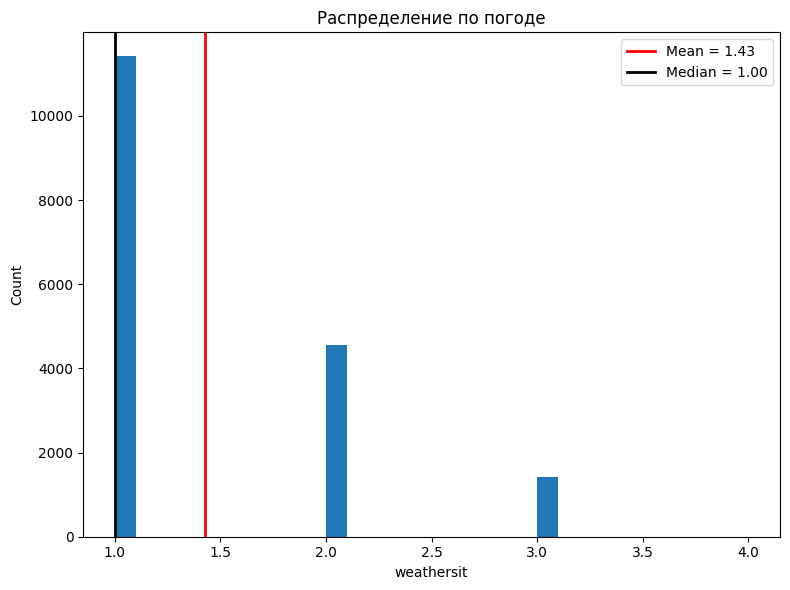

In [8]:
plot_hist(df, "temp", title="Распределение по температуре", midline=True, mx=1.0, mn=0.0)
plot_hist(df, "hum", title="Распределение по влажности", midline=True, mx=1.0, mn=0.0)
plot_hist(df, "windspeed", title="Распределение по скорости ветра", midline=True, mx=1.0, mn=0.0)
plot_hist(df, "cnt", title="Распределение по количеству клиентов")
plot_hist(df, "weathersit", title="Распределение по погоде")


- Распределение темперетуры близко к нормальному. Нельзя сказать, какая температура наиболее "привычна", потому что неизвестно минимальное значение до нормализации
- Наиболее привычная (частая) влажность около 63%
- Ветренная погода достаточно редка
- Очевидно, преобладают часы простоя, но в общем число клиентов держится в районе 150-200

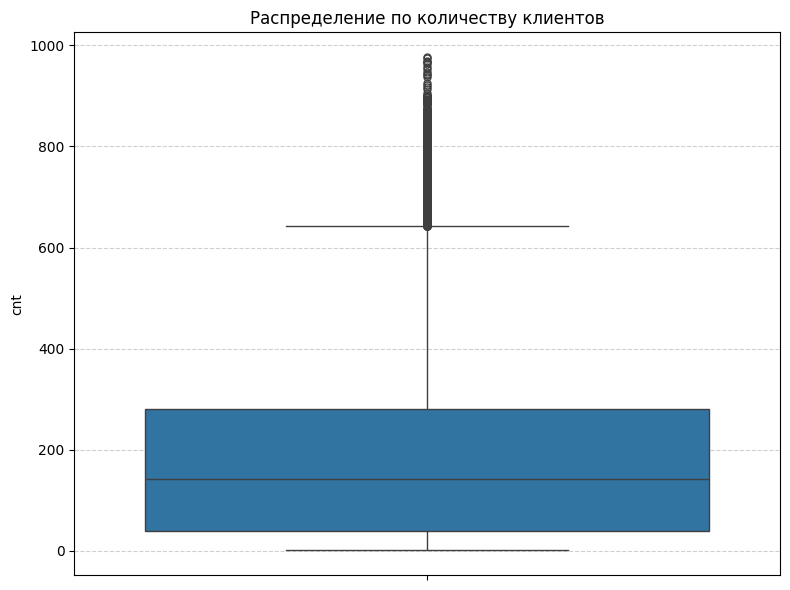

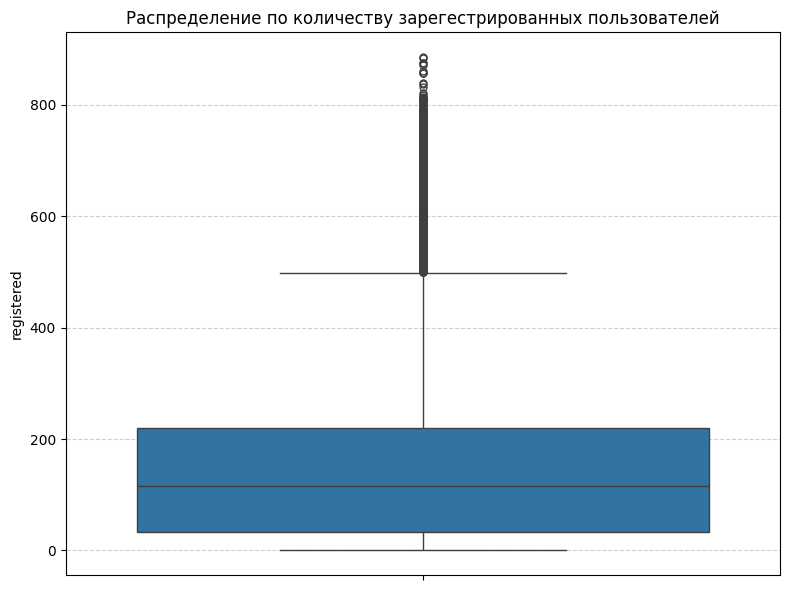

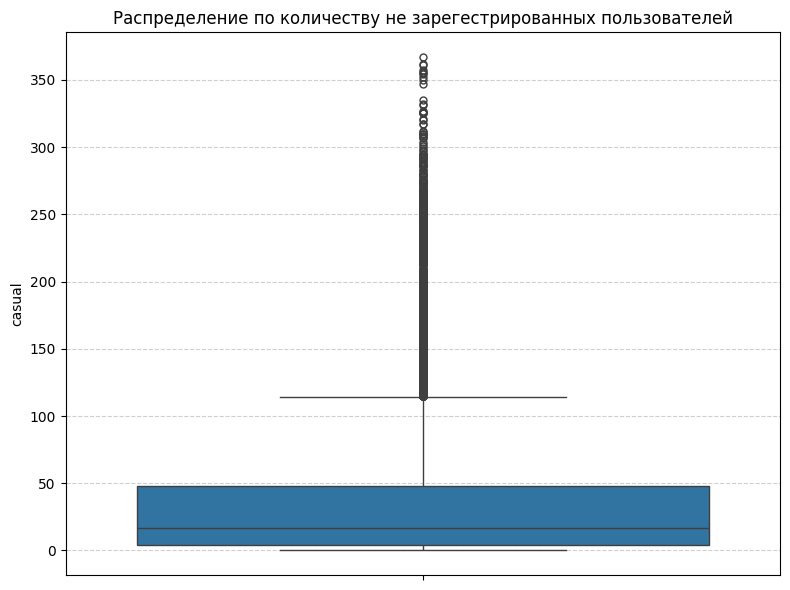

In [9]:
plot_box(df, "cnt", title="Распределение по количеству клиентов")
plot_box(df, "registered", title="Распределение по количеству зарегестрированных пользователей")
plot_box(df, "casual", title="Распределение по количеству не зарегестрированных пользователей")

- Число зарегистрированных пользоавтелей преобладает над числом "гостевых"
- Число клиентов Держится в районе 50-250 в час

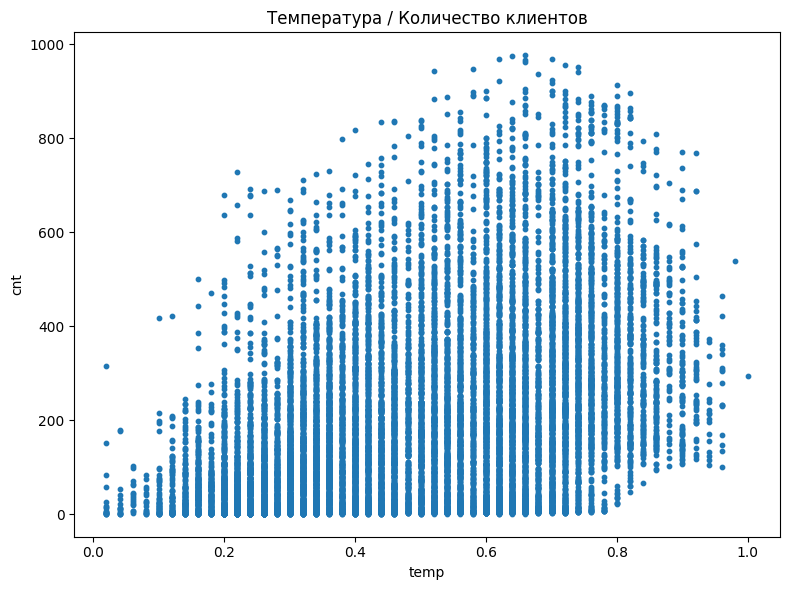

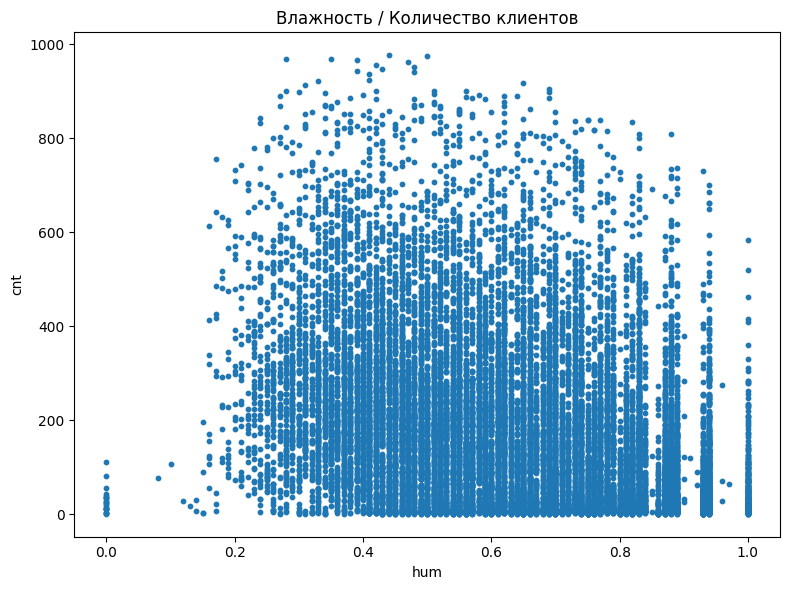

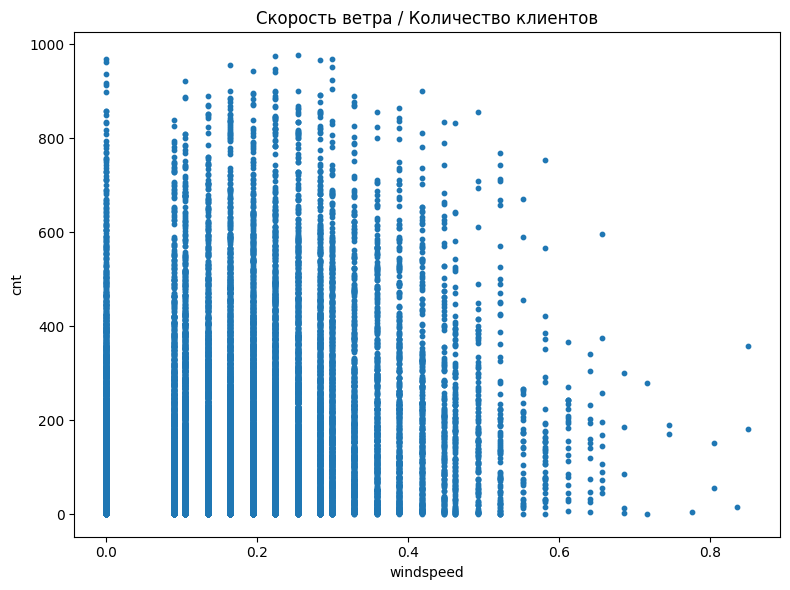

In [10]:
plot_scatter(df, "temp", "cnt", title="Температура / Количество клиентов")
plot_scatter(df, "hum", "cnt", title="Влажность / Количество клиентов")
plot_scatter(df, "windspeed", "cnt", title="Скорость ветра / Количество клиентов")

- В жаркую погоду не бывает мало клиентов
- В холодную погоду никто не хочет кататься
- Наибольшее число клиентов достигается при значении температуры около 0.6
- В силу большей заинтересованности в тёплую погоду высокая влажность отталкивает клиентов и самые доходные часы имеют пониженную влажность
- Чем ниже скорость ветра, тем больше клиентов

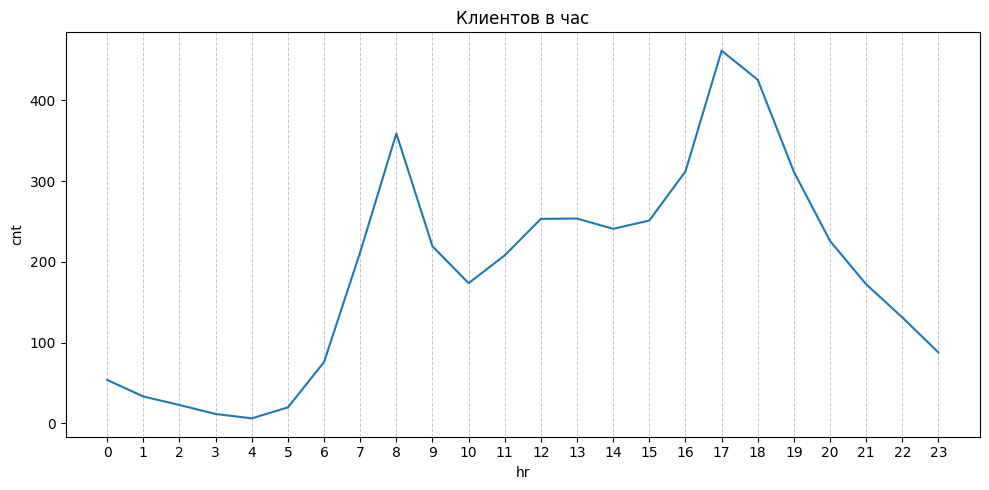

In [11]:
hour_mean = df.groupby("hr")["cnt"].mean().reset_index()
plot_line(hour_mean, "hr", "cnt", title="Клиентов в час", xticks=range(0, 24), xgrid=True)

- Заметны пики в 8 и 17 часов -- в это время многие добираются на работу или домой, поэтому спрос подскакивает
- Ночью почти нет клиентов
- Есть подъём спроса в обед. Вероятно, кто-то добирается поесть

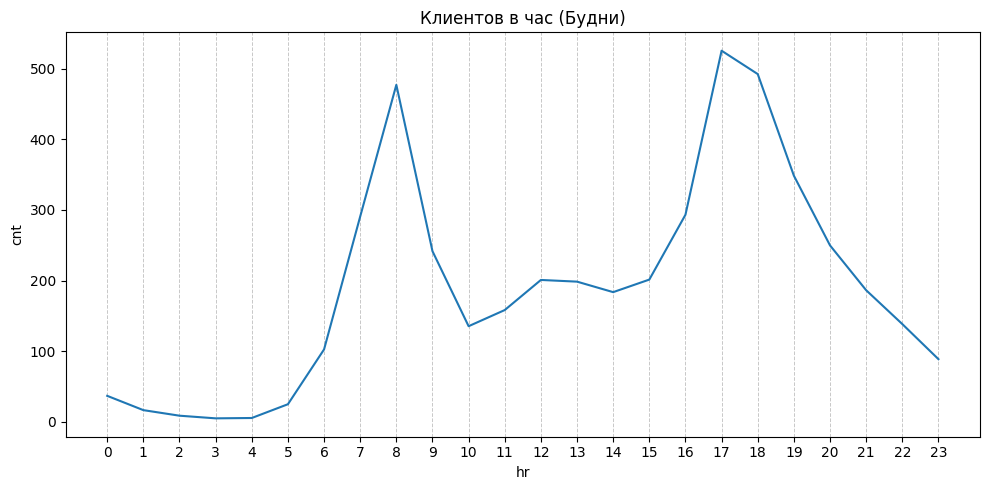

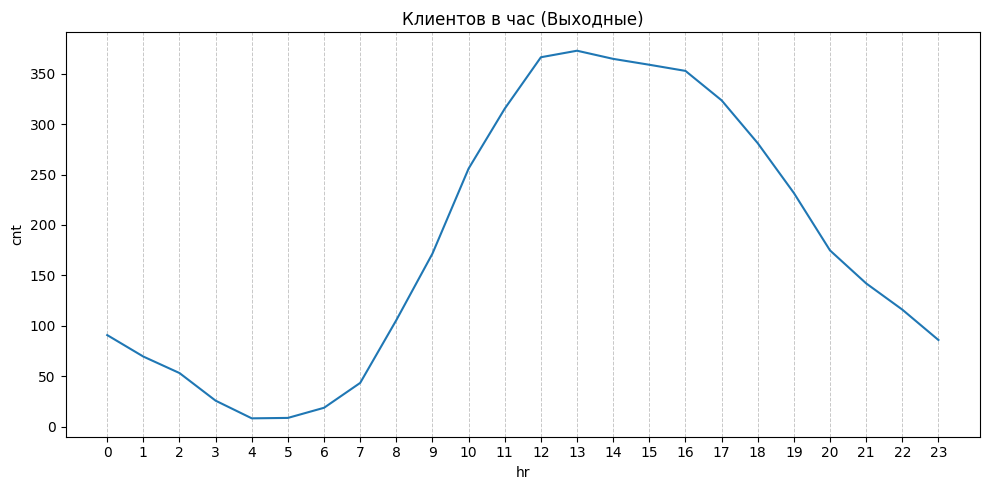

In [12]:
work = df[df["workingday"] == 1].groupby("hr")["cnt"].mean().reset_index()
nowork = df[df["workingday"] == 0].groupby("hr")["cnt"].mean().reset_index()

plot_line(work, "hr", "cnt", title="Клиентов в час (Будни)", xticks=range(0, 24), xgrid=True)
plot_line(nowork, "hr", "cnt", title="Клиентов в час (Выходные)", xticks=range(0, 24), xgrid=True)

- В будние дни отчётливо видны пики спроса утром и вечером - люди перебираются между работой и домом
- Есть небольшой подъём спроса в обед
- Ночью почти нет клиентов
- В выходные Распределение спроса близко к нормальному с пиком период с 12 до 16 часов - днём

# Построим baseline

Для бейзлайна вполне подойдет линейная регрессия.

In [13]:
df

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
0            1  2011-01-01       1   0     1   0        0        6   
1            2  2011-01-01       1   0     1   1        0        6   
2            3  2011-01-01       1   0     1   2        0        6   
3            4  2011-01-01       1   0     1   3        0        6   
4            5  2011-01-01       1   0     1   4        0        6   
...        ...         ...     ...  ..   ...  ..      ...      ...   
17374    17375  2012-12-31       1   1    12  19        0        1   
17375    17376  2012-12-31       1   1    12  20        0        1   
17376    17377  2012-12-31       1   1    12  21        0        1   
17377    17378  2012-12-31       1   1    12  22        0        1   
17378    17379  2012-12-31       1   1    12  23        0        1   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
0               0           1  0.24  0.2879  0.81     0.0000       3   
1               0           1  0.22  0.2727  0.80     0.0000       8   
2               0           1  0.22  0.2727  0.80     0.0000       5   
3               0           1  0.24  0.2879  0.75     0.0000       3   
4               0           1  0.24  0.2879  0.75     0.0000       0   
...           ...         ...   ...     ...   ...        ...     ...   
17374           1           2  0.26  0.2576  0.60     0.1642      11   
17375           1           2  0.26  0.2576  0.60     0.1642       8   
17376           1           1  0.26  0.2576  0.60     0.1642       7   
17377           1           1  0.26  0.2727  0.56     0.1343      13   
17378           1           1  0.26  0.2727  0.65     0.1343      12   

       registered  cnt  
0              13   16  
1              32   40  
2              27   32  
3              10   13  
4               1    1  
...           ...  ...  
17374         108  119  
17375          81   89  
17376          83   90  
17377          48   61  
17378          37   49  

[17379 rows x 17 columns]

In [14]:
X = df.drop(['cnt', 'dteday', 'registered', 'casual'], axis=1)
y = df['cnt']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [17]:
y_pred = model.predict(X_test)

In [18]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

MSE: 19376.95
RMSE: 139.20
MAE: 104.80
R²: 0.3881


# Этап 2. Работа с аномалиями и генерация признаков

In [19]:
df['cnt_z'] = (df['cnt'] - df['cnt'].mean()) / df['cnt'].std()

df_outliers_cnt = df[np.abs(df['cnt_z']) > 3]

print(df_outliers_cnt[['dteday', 'hr', 'cnt', 'casual', 'registered']].head())

           dteday  hr  cnt  casual  registered
10383  2012-03-13  18  734      96         638
10406  2012-03-14  17  782     140         642
10407  2012-03-14  18  749     102         647
10431  2012-03-15  18  746      98         648
10527  2012-03-19  18  801     120         681


Это не выбросы, они показывают пик спроса у офисных работников в вечерний час-пик в середине марта

Добавим признаки, показыающие часы пик

In [20]:
df['is_rush_hour'] = df['hr'].isin([8, 17, 18]).astype(int)
df['is_weekday_rush'] = ((df['workingday'] == 1) & df['hr'].isin([17, 18])).astype(int)
df['registered_ratio'] = df['registered'] / (df['cnt'] + 1e-5)
df = df.sort_values(['dteday', 'hr'])
df['cnt_lag_24h'] = df['cnt'].shift(24)
df['hour_mean_cnt'] = df.groupby('hr')['cnt'].transform('mean')

Добавим Target Encoding без утечек

In [21]:
def target_encode(train_series, target, test_series, k=5, smooth=10):
    # mean target
    global_mean = target.mean()

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    train_encoded = np.zeros(len(train_series))
    for idx_train, idx_val in kf.split(train_series):
        train_fold, val_fold = train_series.iloc[idx_train], train_series.iloc[idx_val]
        target_fold = target.iloc[idx_train]

        means = target_fold.groupby(train_fold).mean()
        counts = train_fold.value_counts()

        smooth_means = ((counts * means) + (smooth * global_mean)) / (counts + smooth)

        train_encoded[idx_val] = val_fold.map(smooth_means).fillna(global_mean)

    means = target.groupby(train_series).mean()
    counts = train_series.value_counts()

    smooth_means = ((counts * means) + (smooth * global_mean)) / (counts + smooth)

    test_encoded = test_series.map(smooth_means).fillna(global_mean)

    return train_encoded, test_encoded

In [22]:
train_te, test_te = target_encode(df['hr'], df['cnt'], df['hr'])

df['hr_te'] = train_te

Применим IQR

In [23]:
num_cols = ['cnt', 'casual', 'registered', 'temp', 'atemp', 'hum', 'windspeed']

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # флаг выброса
    df[f'{col}_outlier'] = ((df[col] < lower) | (df[col] > upper)).astype(int)

    print(f"{col}: {df[f'{col}_outlier'].sum()} выбросов")

cnt: 505 выбросов
casual: 1192 выбросов
registered: 680 выбросов
temp: 0 выбросов
atemp: 0 выбросов
hum: 22 выбросов
windspeed: 342 выбросов


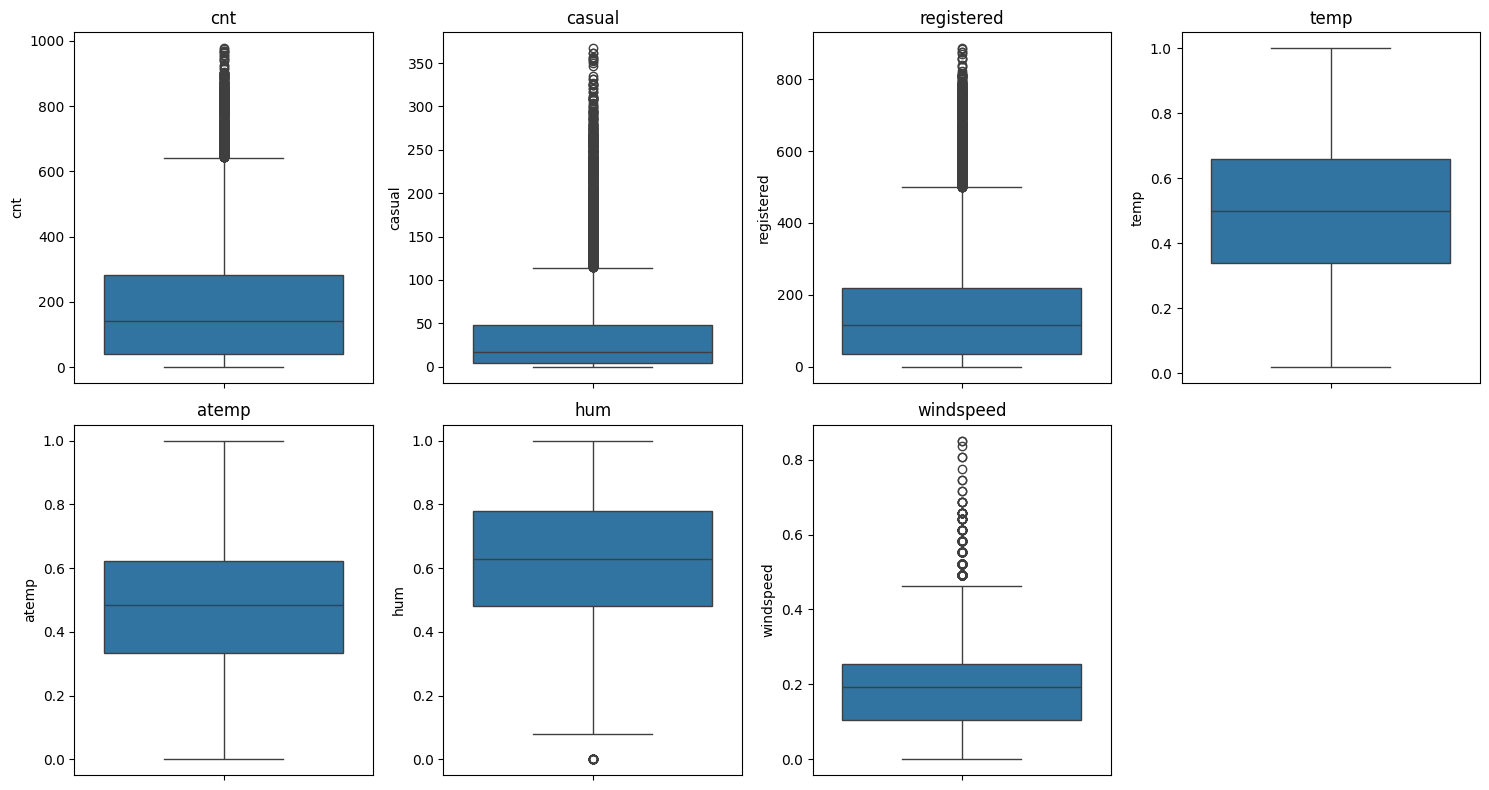

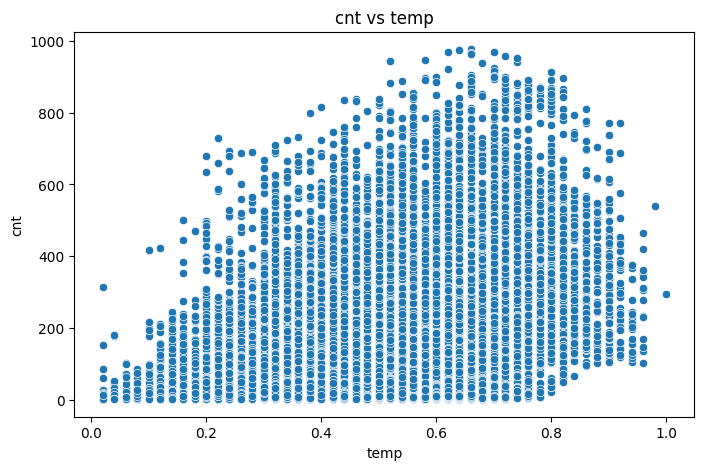

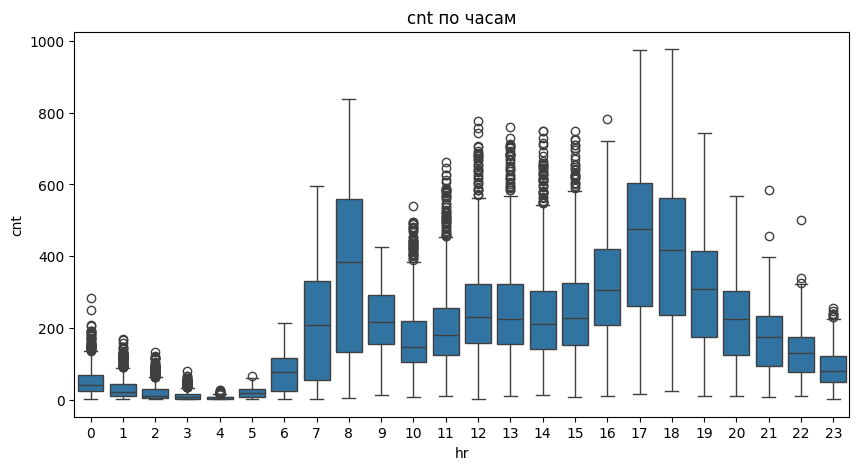

In [24]:
num_cols = ['cnt', 'casual', 'registered', 'temp', 'atemp', 'hum', 'windspeed']

# Boxplots
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x='temp', y='cnt', data=df)
plt.title('cnt vs temp')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='hr', y='cnt', data=df)
plt.title('cnt по часам')
plt.show()

cnt/casual/registered - пики спроса и уже созданы признаки под них
temp/atemp - выбросов нет
hum/windspeed - KNNImputer

In [25]:
imputer = KNNImputer(n_neighbors=5)
df[['hum','windspeed']] = imputer.fit_transform(df[['hum','windspeed']])

In [26]:
df

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
0            1  2011-01-01       1   0     1   0        0        6   
1            2  2011-01-01       1   0     1   1        0        6   
2            3  2011-01-01       1   0     1   2        0        6   
3            4  2011-01-01       1   0     1   3        0        6   
4            5  2011-01-01       1   0     1   4        0        6   
...        ...         ...     ...  ..   ...  ..      ...      ...   
17374    17375  2012-12-31       1   1    12  19        0        1   
17375    17376  2012-12-31       1   1    12  20        0        1   
17376    17377  2012-12-31       1   1    12  21        0        1   
17377    17378  2012-12-31       1   1    12  22        0        1   
17378    17379  2012-12-31       1   1    12  23        0        1   

       workingday  weathersit  ...  cnt_lag_24h  hour_mean_cnt       hr_te  \
0               0           1  ...          NaN      53.898072   56.403508   
1               0           1  ...          NaN      33.375691   35.669968   
2               0           1  ...          NaN      22.869930   25.792762   
3               0           1  ...          NaN      11.727403   15.075242   
4               0           1  ...          NaN       6.352941    9.602242   
...           ...         ...  ...          ...            ...         ...   
17374           1           2  ...        102.0     311.523352  311.407600   
17375           1           2  ...         72.0     226.030220  229.157536   
17376           1           1  ...         47.0     172.314560  176.904536   
17377           1           1  ...         36.0     131.335165  133.121456   
17378           1           1  ...         49.0      87.831044   89.121408   

       cnt_outlier  casual_outlier  registered_outlier  temp_outlier  \
0                0               0                   0             0   
1                0               0                   0             0   
2                0               0                   0             0   
3                0               0                   0             0   
4                0               0                   0             0   
...            ...             ...                 ...           ...   
17374            0               0                   0             0   
17375            0               0                   0             0   
17376            0               0                   0             0   
17377            0               0                   0             0   
17378            0               0                   0             0   

       atemp_outlier  hum_outlier  windspeed_outlier  
0                  0            0                  0  
1                  0            0                  0  
2                  0            0                  0  
3                  0            0                  0  
4                  0            0                  0  
...              ...          ...                ...  
17374              0            0                  0  
17375              0            0                  0  
17376              0            0                  0  
17377              0            0                  0  
17378              0            0                  0  

[17379 rows x 31 columns]

Применим тест Граббса на технических признаках, так как cnt, casual< registered не имеют выбросов, а лишь показывают естественные пики спроса

In [27]:

df = df.copy()

def grubbs_outliers(x, alpha=0.05):
    x = np.array(x)
    n = len(x)
    mean_x = np.mean(x)
    std_x = np.std(x, ddof=1)

    diff = np.abs(x - mean_x)
    max_idx = np.argmax(diff)

    G = diff[max_idx] / std_x

    t = stats.t.ppf(1 - alpha/(2*n), n - 2)
    G_crit = ((n - 1)/np.sqrt(n)) * np.sqrt(t**2 / (n - 2 + t**2))

    if G > G_crit:
        return [max_idx]
    else:
        return []

for col in ['hum', 'windspeed']:
    out_idx = grubbs_outliers(df[col], alpha=0.05)
    df[f'{col}_grubbs_outlier'] = 0
    if out_idx:
        df.loc[out_idx, f'{col}_grubbs_outlier'] = 1
    print(f"{col}: {len(out_idx)} выбросов по Граббсу")

hum: 0 выбросов по Граббсу
windspeed: 1 выбросов по Граббсу


In [28]:
df['windspeed_grubbs_outlier'] = 0
out_idx = grubbs_outliers(df['windspeed'])
if out_idx:
    df.loc[out_idx, 'windspeed_grubbs_outlier'] = 1

Применим IsolationForest для поиска аномальных значений

In [29]:
X = df[['hum', 'windspeed']].values

In [30]:
clf = IForest(contamination=0.01, random_state=42)
clf.fit(X)

df['iforest_outlier'] = clf.labels_
df['iforest_score'] = clf.decision_scores_

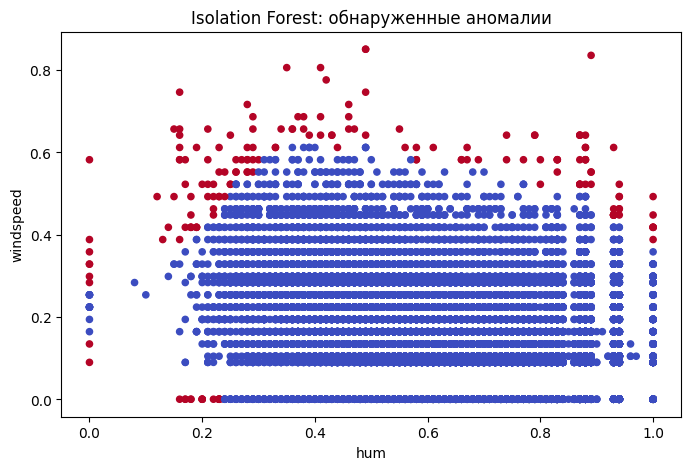

In [31]:
plt.figure(figsize=(8,5))
plt.scatter(df['hum'], df['windspeed'], c=df['iforest_outlier'], cmap='coolwarm', s=20)
plt.xlabel('hum')
plt.ylabel('windspeed')
plt.title('Isolation Forest: обнаруженные аномалии')
plt.show()

In [32]:
y_true = df['windspeed_grubbs_outlier']
y_pred = df['iforest_outlier']

print('Precision:', precision_score(y_true, y_pred))
print('Recall:', recall_score(y_true, y_pred))
print('F1:', f1_score(y_true, y_pred))
print('ROC-AUC:', roc_auc_score(y_true, df['iforest_score']))

Precision: 0.005847953216374269
Recall: 1.0
F1: 0.011627906976744186
ROC-AUC: 0.9950224421682587


Выбросов очень мало, что еще раз было подтверждено методом Isolataion Forest

In [33]:
df = pd.get_dummies(df, columns=['season', 'weathersit', 'weekday'], drop_first=True)

Развернем времннеы признаки через синус/косинус-кодирование: часы, дни недели, месяцы. А ещё добавим признаки праздников, выходных, часов пика или погодных условий

In [34]:
weekday_cols = [f'weekday_{i}' for i in range(1,7)]

weekday_max = df[weekday_cols].idxmax(axis=1)

df['weekday_num'] = weekday_max.apply(lambda x: int(x.split('_')[1]))

df['weekday_sin'] = np.sin(2 * np.pi * df['weekday_num'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday_num'] / 7)

### Отбор признаков

In [35]:
num_cols = ['temp','atemp','hum','windspeed','cnt_lag_24h','hour_mean_cnt','hr_te','registered_ratio']
corr = df[num_cols + ['cnt']].corr()['cnt'].sort_values(ascending=False)
print(corr)

cnt                 1.000000
cnt_lag_24h         0.815765
hour_mean_cnt       0.708162
hr_te               0.706725
temp                0.404772
atemp               0.400929
windspeed           0.093234
registered_ratio   -0.123605
hum                -0.322911
Name: cnt, dtype: float64


In [36]:
categorical_cols = ['season_2','season_3','season_4','weathersit_2','weathersit_3','weathersit_4','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6','is_rush_hour','is_weekday_rush','holiday','workingday']
anova_scores, p_values = f_classif(df[categorical_cols], df['cnt'])
anova_results = pd.DataFrame({'feature': categorical_cols, 'F_score': anova_scores, 'p_value': p_values}).sort_values('F_score', ascending=False)
print(anova_results)

            feature    F_score       p_value
13  is_weekday_rush  11.026265  0.000000e+00
12     is_rush_hour   9.100973  0.000000e+00
1          season_3   1.899319  2.865112e-47
15       workingday   1.407288  1.216063e-13
9         weekday_4   1.205328  4.514801e-05
2          season_4   1.203753  5.070228e-05
0          season_2   1.178082  3.064634e-04
8         weekday_3   1.137539  3.651590e-03
7         weekday_2   1.106534  1.778451e-02
11        weekday_6   1.075191  6.642681e-02
10        weekday_5   1.051976  1.465263e-01
4      weathersit_3   1.016600  3.632109e-01
6         weekday_1   0.986117  6.058401e-01
3      weathersit_2   0.958406  8.002028e-01
14          holiday   0.734735  1.000000e+00
5      weathersit_4   0.381720  1.000000e+00


In [37]:
X = df.drop(['cnt','dteday','casual','registered'], axis=1)
y = df['cnt']

X = X.fillna(X.mean())

# model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# rfecv = RFECV(estimator=model, step=1, cv=3, scoring='r2')
# rfecv.fit(X, y)

# selected_features = X.columns[rfecv.support_]
# print("Выбранные признаки:", selected_features)

In [38]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)

importance = pd.Series(np.abs(lasso.coef_), index=X.columns)
selected_features_l1 = importance[importance > 0].index
print(selected_features_l1)

Index(['instant', 'cnt_lag_24h', 'hour_mean_cnt'], dtype='object')


**Вывод по отбору признаков:**

**Однозначно оставить (сильная корреляция + ANOVA):**

cnt_lag_24h, hour_mean_cnt, hr_te, is_rush_hour, is_weekday_rush, season_3, workingday, temp, atemp.

**Менее значимые:**

hum, windspeed, registered_ratio, менее значимые дни недели и weather sit

**Исключить:**

holiday, weathersit_4, weekday_1 и прочие с F-score ≈ 1 или p-value ≈ 1

In [39]:

# --- Базовые признаки ---
base_features = [
    'cnt_lag_24h', 'hour_mean_cnt', 'hr_te',
    'is_rush_hour', 'is_weekday_rush', 'season_3',
    'workingday', 'temp', 'atemp'
]

extra_features = ['hum', 'windspeed', 'registered_ratio',
                  'weekday_2','weekday_3','weekday_4','weekday_5','weekday_6',
                  'weathersit_2','weathersit_3']  # можно добавить/убрать по желанию

# --- Подготовка данных ---
X_base = df[base_features].fillna(df[base_features].mean())
X_extra = df[base_features + extra_features].fillna(df[base_features + extra_features].mean())
y = df['cnt']


X_train_b, X_test_b, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)
X_train_e, X_test_e, _, _ = train_test_split(X_extra, y, test_size=0.2, random_state=42)
# --- Инициализация модели ---
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

# --- Базовая модель ---
cat_model.fit(X_train_b, y_train, eval_set=(X_test_b, y_test), early_stopping_rounds=50)
y_pred_b = cat_model.predict(X_test_b)

print("Базовая модель")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_b)))
print("R2:", r2_score(y_test, y_pred_b))

# --- Расширенная модель ---
cat_model.fit(X_train_e, y_train, eval_set=(X_test_e, y_test), early_stopping_rounds=50)
y_pred_b = cat_model.predict(X_test_e)

print("Экспериментальная модель")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_b)))
print("R2:", r2_score(y_test, y_pred_b))

0:	learn: 175.8357895	test: 171.6967782	best: 171.6967782 (0)	total: 61.9ms	remaining: 1m 1s
100:	learn: 77.4759950	test: 76.6175653	best: 76.6175653 (100)	total: 837ms	remaining: 7.45s
200:	learn: 72.5432686	test: 73.3338630	best: 73.3338630 (200)	total: 1.73s	remaining: 6.88s
300:	learn: 69.0075487	test: 70.9349539	best: 70.9338220 (299)	total: 2.33s	remaining: 5.42s
400:	learn: 66.5640924	test: 69.4769485	best: 69.4769485 (400)	total: 2.92s	remaining: 4.37s
500:	learn: 64.9305189	test: 68.8074853	best: 68.8074853 (500)	total: 3.76s	remaining: 3.74s
600:	learn: 63.7196639	test: 68.4479362	best: 68.4479362 (600)	total: 4.28s	remaining: 2.84s
700:	learn: 62.6671486	test: 68.2006786	best: 68.1949140 (691)	total: 5.56s	remaining: 2.37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 68.17116874
bestIteration = 745

Shrink model to first 746 iterations.
Базовая модель
RMSE: 68.17116873788137
R2: 0.853237079483689
0:	learn: 175.9542111	test: 171.8293909	best: 171.8293909 

RMSE уменьшился в 2.5 раза!!!

# Этап 3. Интерпретация и диагностика сдвига данных.

## Шаг 1. Проинтерпретируйте модели

###Шаг 1.1 Постройте глобальные интерпретации минимум для двух разных классов моделей с помощью LIME и SHAP. (SHAP)

In [40]:
import shap
from lime.lime_tabular import LimeTabularExplainer
from lime import submodular_pick

у нас уже есть древесный catboost, используем еще линейный LinearRegression.

In [41]:
lin_model = LinearRegression()
lin_model.fit(X_train_e, y_train)
y_pred = lin_model.predict(X_test_e)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

MSE: 7858.62
RMSE: 88.65
MAE: 60.08
R²: 0.7518


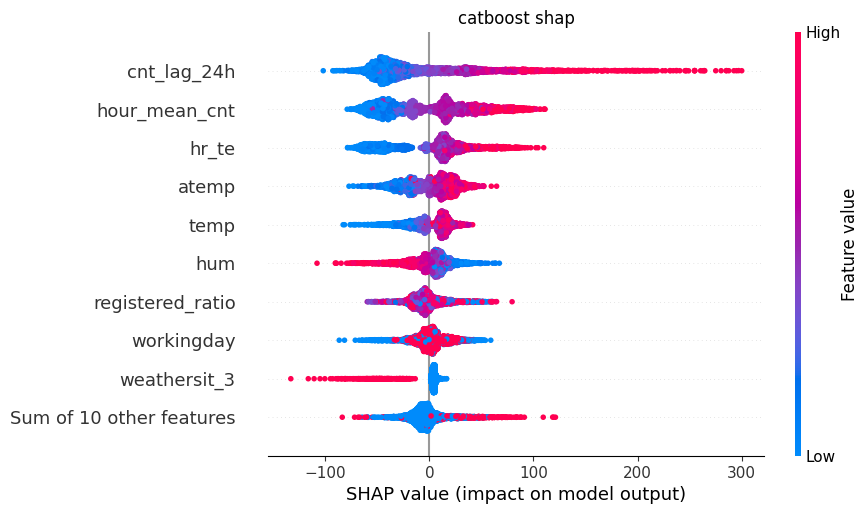

In [42]:
explainer_cat = shap.TreeExplainer(cat_model)
shap_values_cat = explainer_cat(X_test_e)

plt.title("catboost shap")
shap.plots.beeswarm(shap_values_cat)
plt.show()

Больше всего на увеличение кол-ва аренды в catboost влияют сгенерированные признаки cnt_lag_24h, hour_mean_cnt, и hr_te


PermutationExplainer explainer: 3477it [01:25, 38.06it/s]                          


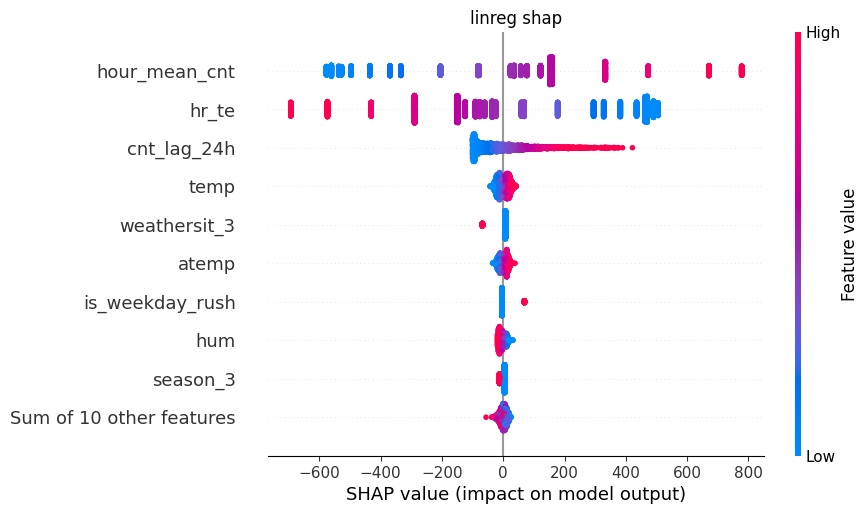

In [43]:
explainer_lin = shap.Explainer(lin_model.predict, X_train_e.astype(float))
shap_values_lin = explainer_lin(X_test_e.astype(float))

plt.title("linreg shap")
shap.plots.beeswarm(shap_values_lin)
plt.show()

в линейной модели очень сильно влияет hour_mean_cnt и hr_te. не так сильно влияет cnt_lag_24h

### 1.2 Сравните, совпадают ли ключевые признаки и направления влияния между моделями (SHAP)

В целом, в shap глобально ключевые признаки (топ 3) и направления влияния совпадают между линейной и деревянной моделью. Не совпадает лишь hr_te - в catboost увеличение этого признака положительно сказывается на аренде, а в linear regression увеличение этого признака отрицательно влияет на аренду. Также в линейной модели очень большие значение shap у hour_mean_cnt и ht_re - это значит, что малое изменение в данных признаках будет иметь большое влияние на выход модели. это плохо.

### 1.1 Теперь посторим глобальные интерпретации для LIME для двух моделей.

In [44]:
from lime import submodular_pick

explainer_lime = LimeTabularExplainer(
  training_data=np.array(X_train_e),
  feature_names=X_train_e.columns,
  mode='regression',
)

def lin_predict(X):
  X = pd.DataFrame(X, columns=X_train_e.columns)
  return lin_model.predict(X)

def cat_predict(X):
  X = pd.DataFrame(X, columns=X_train_e.columns)
  return cat_model.predict(X)

In [45]:
cat_sp_obj = submodular_pick.SubmodularPick(
  explainer_lime,
  X_test_e.values,
  cat_predict,
  num_features=8, # Сколько переменных хотим использовать
  num_exps_desired=10 # На основе какого количества наблюдений будем строить глобальную интерпретацию. Здесь чем больше — тем лучше
)

In [46]:
lin_sp_obj = submodular_pick.SubmodularPick(
  explainer_lime,
  X_test_e.values,
  lin_predict,
  num_features=8, # Сколько переменных хотим использовать
  num_exps_desired=10 # На основе какого количества наблюдений будем строить глобальную интерпретацию. Здесь чем больше — тем лучше
)

In [49]:
# # Собираем весовые коэффициенты всех переменных в одну таблицу
# W_pick = pd.DataFrame([dict(sp.as_list(sp.available_labels()[0])) for sp in sp_obj.sp_explanations]).fillna(0)
# W_pick['prediction'] = [sp.available_labels()[0] for sp in sp_obj.sp_explanations]

# # Чтобы получить глобальные интерпретации, усредняем веса по каждой переменной
# aggregate_importances = W_pick.drop("prediction", axis=1).mean(axis=0).sort_values(ascending=False, key=np.abs)
# print(aggregate_importances)

код из семинара не работает для регрессии - как пофиксить - не понял.

###1.3 Постройте локальные интерпретации LIME и SHAP для одного выбранного наблюдения.

In [50]:
idx = 10

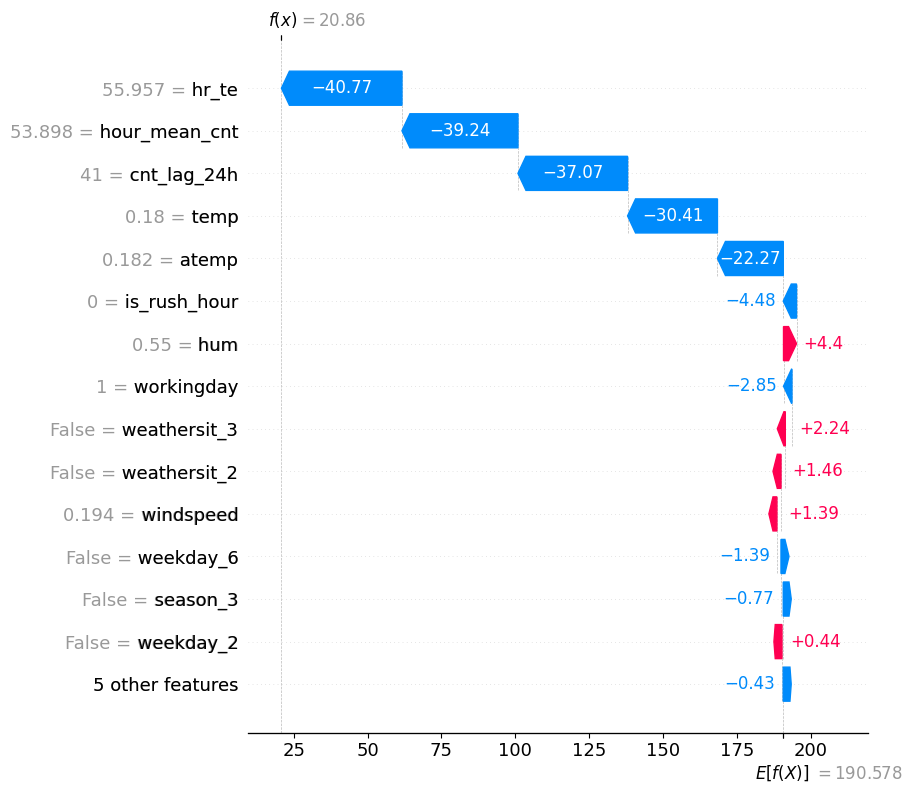

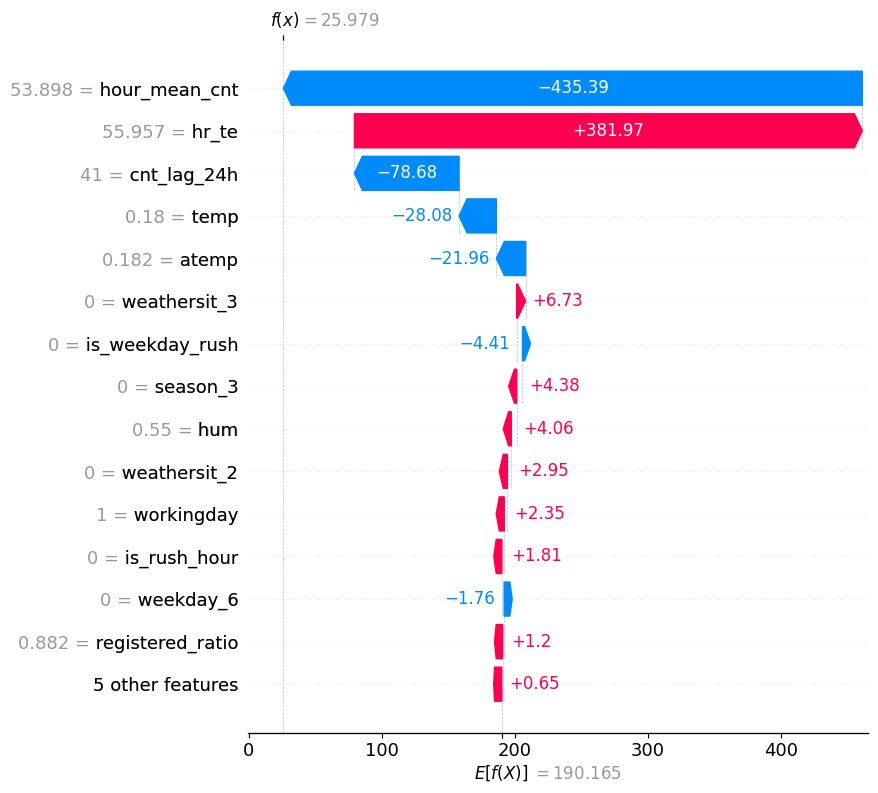

In [51]:
shap.plots.waterfall(shap_values_cat[idx], max_display=15)
plt.show()

shap.plots.waterfall(shap_values_lin[idx], max_display=15)
plt.show()

Из-за того, что hr_te в разных моделях направлен в разные стороны - в линейной модели больше изменение от hour_mean_cnt, т.к. нужно "погасить" hr_te, направленный в обратную сторону. Прогноз немного отличается у двух моделей.

In [52]:
explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train_e),
    feature_names=X_train_e.columns,
    mode='regression',
)


In [53]:
def lime_explain(explainer, data, predict_method, num_features):
  '''
  explainer — класс LIME
  data — наблюдение для интерпретации
  predict_method — метод для получения предсказания
  num_features — количество признаков, которые нужно выводить
  '''
  explanation = explainer.explain_instance(data, predict_method, num_features=num_features)
  return explanation

In [54]:
explanation = lime_explain(explainer_lime, X_test_e.iloc[idx], cat_model.predict, 10)
explanation.show_in_notebook(show_table=True)

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

In [55]:
explanation = lime_explain(explainer_lime, X_test_e.iloc[idx], lin_model.predict, 10)
explanation.show_in_notebook(show_table=True)

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Наибольшее влияение оказали признаки  hour_mean_cnt и hr_te.  В целом, выводы lime и shap не сильно различаются для двух главных признаков (hour_mean_cnt и hr_te), но различаются для остальных признаков - они по разному оценивают влияние второстепенных признаков -  к примеру, в лайм почему-то wheatersit_3 выходит в топ 4, хотя в shap он топ 5+.

## Шаг 2. Постройте SHAP-эмбеддинги и проанализируйте сдвиги

In [56]:
def get_shap_embeddings_tree(X):
    shap_values = explainer_cat.shap_values(X)
    shap_df = pd.DataFrame(shap_values, columns=X.columns, index=X.index)
    return shap_df
def get_shap_embeddings_lin(X):
    shap_values = explainer_lin.shap_values(X)
    shap_df = pd.DataFrame(shap_values, columns=X.columns, index=X.index)
    return shap_df

In [57]:
shap_train_df = get_shap_embeddings_tree(X_train_e.astype(float))
shap_test_df  = get_shap_embeddings_tree(X_test_e.astype(float))

In [58]:
shift_metrics = pd.DataFrame({
    col: [shap_train_df[col].mean(), shap_test_df[col].mean(),
          shap_test_df[col].mean() - shap_train_df[col].mean()]
    for col in X_train_e.columns
}, index=['train_mean','test_mean','diff']).T
print("cдвиги по признакам train и test:")
print(shift_metrics.sort_values('diff', key=abs, ascending=False))

cдвиги по признакам train и test:
                  train_mean  test_mean      diff
cnt_lag_24h        -1.208770  -3.384736 -2.175966
hour_mean_cnt       0.161802  -0.718102 -0.879904
hr_te               0.524384  -0.109725 -0.634109
hum                 0.309157  -0.097207 -0.406364
registered_ratio   -1.967302  -2.337652 -0.370350
workingday          1.321184   0.963736 -0.357448
weekday_5          -0.106215   0.166158  0.272372
weathersit_3        0.113728  -0.080849 -0.194577
weekday_6           0.067553  -0.111738 -0.179291
atemp               1.021821   0.863678 -0.158143
temp                0.354150   0.198065 -0.156085
is_rush_hour       -0.130511  -0.268010 -0.137499
windspeed           0.080473  -0.044896 -0.125368
weekday_4          -0.736473  -0.649190  0.087283
weekday_3           0.156331   0.109732 -0.046600
is_weekday_rush     0.116271   0.160604  0.044332
weekday_2          -0.036463  -0.003252  0.033210
season_3            0.036984   0.053563  0.016579
weathersit_2    

больше всего сдвиг в распределении признака cnt_lag_24h. скорее всего, это из-за того, что в test большая часть записей может оказаться из "плохого" сезона, в который берут мало велосипедов. то же объяснение можно дать и для hour_mean_cnt. к тому же, test намного меньше train, и в нем просто может не быть записей о большом кол-ве аренды за час,т.к. выборка менее разнообразна.


проверим cnt_lag_24h, hour_mean_cnt, и hr_te

In [59]:
train_shap = shap_train_df[["cnt_lag_24h", "hour_mean_cnt", "hr_te"]].add_prefix("train_").describe()
test_shap = shap_test_df[["cnt_lag_24h", "hour_mean_cnt", "hr_te"]].add_prefix("test_").describe()
display(pd.concat([train_shap['train_cnt_lag_24h'], test_shap['test_cnt_lag_24h'],
                   train_shap['train_hour_mean_cnt'], test_shap['test_hour_mean_cnt'],
                   train_shap['train_hr_te'], test_shap['test_hr_te']], axis = 1).drop("count"))

train_cnt_lag_24h  test_cnt_lag_24h  train_hour_mean_cnt  \
mean          -1.208770         -3.384736             0.161802   
std           60.421279         58.979506            43.074914   
min         -102.321948       -101.868332           -77.207345   
25%          -43.742322        -43.804925           -39.472852   
50%          -24.801687        -25.924413             1.765652   
75%           29.391622         23.886211            31.954684   
max          314.739973        299.957946           115.423613   

      test_hour_mean_cnt  train_hr_te  test_hr_te  
mean           -0.718102     0.524384   -0.109725  
std            42.658488    36.809088   37.226790  
min           -78.904068   -77.297814  -78.582914  
25%           -39.723382   -33.726865  -37.124345  
50%            -0.441935    10.495303   11.447197  
75%            30.474630    22.597858   21.520832  
max           111.139579   110.854563  109.852155

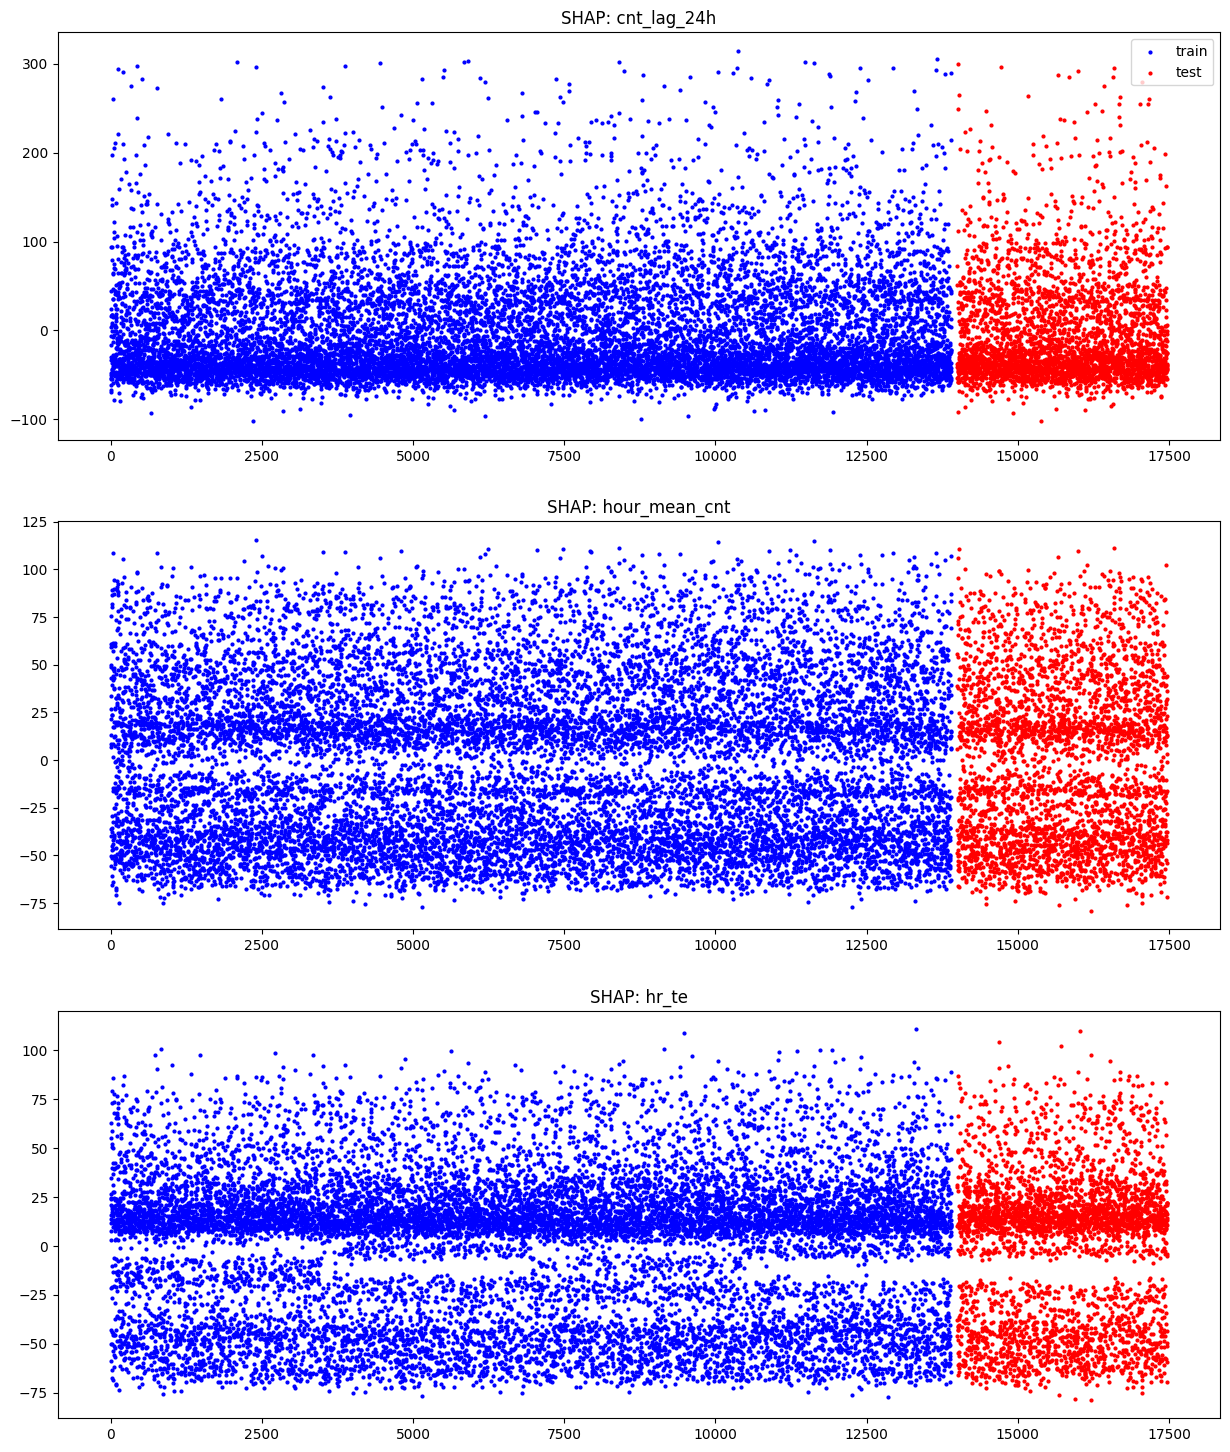

In [60]:
def add_scatter_train_test(ax, col, show_legend=False):
  ax.scatter(
    x=np.arange(len(shap_train_df)),
    y=shap_train_df[col],
    s=4,
    color='blue',
    label='train'
  )
  ax.scatter(
    x=np.arange(14000, 14000 + len(shap_test_df)),
    y=shap_test_df[col],
    s=4,
    color='red',
    label='test'
  )

  ax.set_title(f"SHAP: {col}")

  if show_legend:
    ax.legend()

cols = ["cnt_lag_24h", "hour_mean_cnt", "hr_te"]
fig, axs = plt.subplots(len(cols), 1, figsize=(15, len(cols)*6))
flag = True # Для красивой отрисовки легенды
for ax, col in zip(axs, cols):
  add_scatter_train_test(ax, col, flag)
  flag = False
plt.show()

в целом, нет каких-то заметных сдвигов.
есть какой-то паттерн в hr_te, но это особенность данных.

как таковых аномалий или сдвига в данных я, к сожалению, не нашел, так что нет смысла переобучать модель.

In [61]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

In [62]:
shap_train_df = get_shap_embeddings_tree(X_train_e.astype(float))
shap_test_df  = get_shap_embeddings_tree(X_test_e.astype(float))

In [63]:
pca = PCA(n_components=10)
shap_pca = pca.fit_transform(shap_train_df)
shap_test_pca = pca.transform(shap_test_df)

In [64]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_km = kmeans.fit_predict(shap_pca)
shap_train_df['cluster_km'] = clusters_km
print("распределение по кластерам kmean")
print(pd.Series(clusters_km).value_counts())

распределение по кластерам kmean
0    6364
2    5115
1    2424
Name: count, dtype: int64


In [65]:
agg_cluster = AgglomerativeClustering(n_clusters=3)
clusters_agg = agg_cluster.fit_predict(shap_pca)
shap_train_df['cluster_agg'] = clusters_agg
print("распределение по кластерам AgglomerativeClustering")
print(pd.Series(clusters_agg).value_counts())

распределение по кластерам AgglomerativeClustering
1    5033
2    4939
0    3931
Name: count, dtype: int64


In [66]:
shap_for_pca = shap_train_df.drop(columns=["cluster_agg", "cluster_km"])
pca = PCA(n_components=2, random_state=42)
shap_pca_2 = pca.fit_transform(shap_for_pca)

In [67]:
clusters_plot = shap_train_df['cluster_km'].values

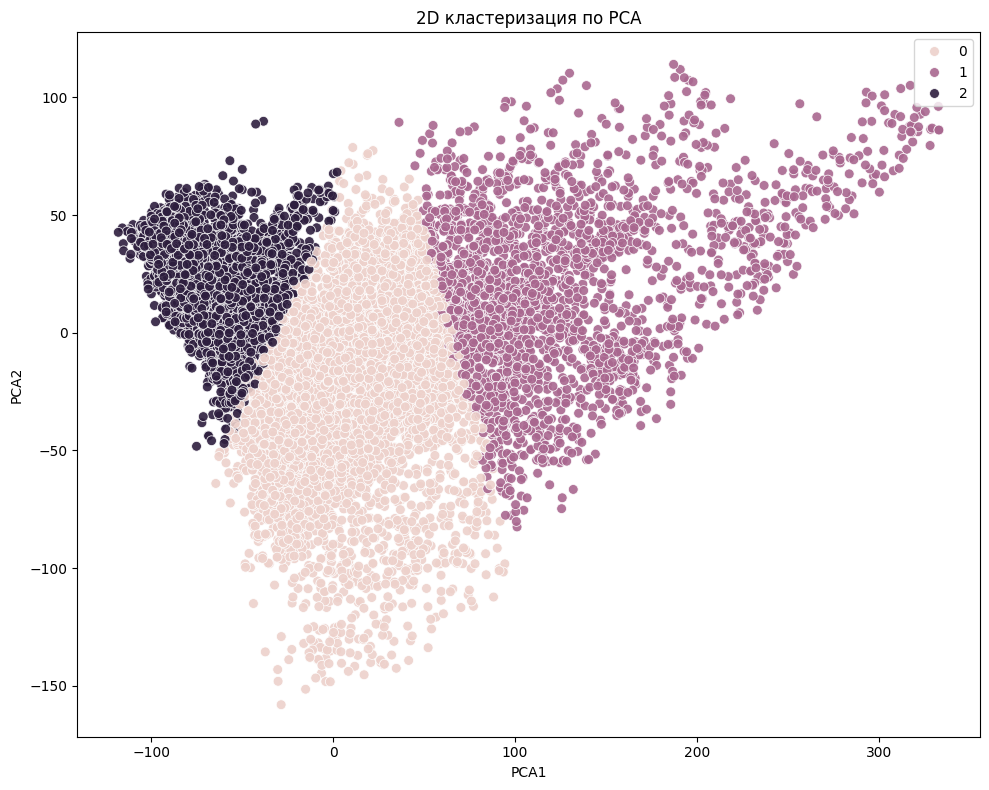

In [68]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=shap_pca_2[:,0], y=shap_pca_2[:,1], hue=clusters_plot, s=50, alpha=0.9)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('2D кластеризация по PCA')
plt.tight_layout()
plt.show()

In [69]:
X_train_clustered = X_train_e.copy()
X_train_clustered['cluster'] = clusters_km
X_test_clustered = X_test_e.copy()
clusters_test_km = kmeans.predict(shap_test_pca)
X_test_clustered['cluster'] = clusters_test_km

In [70]:
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train_clustered, y_train, eval_set=(X_test_clustered, y_test), early_stopping_rounds=50)
y_pred = cat_model.predict(X_test_clustered)

print("модель с кластеризацией")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

0:	learn: 175.7288687	test: 171.6798904	best: 171.6798904 (0)	total: 9.56ms	remaining: 9.55s
100:	learn: 68.1698938	test: 67.9349431	best: 67.9349431 (100)	total: 731ms	remaining: 6.5s
200:	learn: 61.9803382	test: 62.7194901	best: 62.7194901 (200)	total: 1.33s	remaining: 5.29s
300:	learn: 58.2102982	test: 59.8607640	best: 59.8607640 (300)	total: 2.02s	remaining: 4.69s
400:	learn: 55.5796180	test: 58.3204562	best: 58.3204562 (400)	total: 2.43s	remaining: 3.63s
500:	learn: 53.5348985	test: 57.1527325	best: 57.1526963 (499)	total: 3.02s	remaining: 3s
600:	learn: 51.8367596	test: 56.4138748	best: 56.4138748 (600)	total: 3.77s	remaining: 2.5s
700:	learn: 50.3520948	test: 55.7734955	best: 55.7718563 (699)	total: 4.4s	remaining: 1.88s
800:	learn: 49.0093234	test: 55.2644256	best: 55.2644256 (800)	total: 5.21s	remaining: 1.29s
900:	learn: 47.7315908	test: 54.7064015	best: 54.7064015 (900)	total: 5.83s	remaining: 641ms
999:	learn: 46.6645055	test: 54.5152477	best: 54.5088524 (992)	total: 6.27s	

немного ухудшилось кач-во

##  Шаг 3 Shapley Flow

In [71]:
X_all = pd.concat([X_train_e, X_test_e], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)

In [72]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics_list = []
shap_train_list = []
shap_val_list = []

In [73]:
print(X_train_b.shape, y_train.shape, X_train_e.shape)
buf = X_train_b
buf2=y_train
buf3=X_train_e
buf4=y_test

(13903, 9) (13903,) (13903, 19)


In [74]:
fold_idx = 0
cat_params = dict(
    iterations=400,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    silent = True
)
for train_idx, val_idx in kf.split(X_all):
    fold_idx += 1
    print(f"\n=============== fold {fold_idx} ==========")
    X_train_kf, X_val_kf = X_all.iloc[train_idx], X_all.iloc[val_idx]
    y_train_kf, y_val_kf = y_all.iloc[train_idx], y_all.iloc[val_idx]

    baseline = CatBoostRegressor(**cat_params)
    baseline.fit(X_train_kf, y_train_kf, eval_set=(X_val_kf, y_val_kf), early_stopping_rounds=50)
    y_pred_base = baseline.predict(X_val_kf)
    base_rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred_base))
    base_r2 = r2_score(y_val_kf, y_pred_base)

    explainer = shap.TreeExplainer(baseline)
    shap_train = pd.DataFrame(explainer.shap_values(X_train_kf), columns=X_train_kf.columns, index=X_train_kf.index)
    shap_val = pd.DataFrame(explainer.shap_values(X_val_kf), columns=X_val_kf.columns, index=X_val_kf.index)
    shap_train_list.append(shap_train)
    shap_val_list.append(shap_val)

    model_emb = CatBoostRegressor(**cat_params)
    model_emb.fit(shap_train, y_train_kf, eval_set=(shap_val, y_val_kf), early_stopping_rounds=50)
    y_pred_emb = model_emb.predict(shap_val)
    emb_rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred_emb))
    emb_r2 = r2_score(y_val_kf, y_pred_emb)

    shap_train_renamed = shap_train.add_prefix('shap_')
    shap_val_renamed = shap_val.add_prefix('shap_')

    X_train_concat = pd.concat([X_train_kf, shap_train_renamed], axis=1)
    X_val_concat = pd.concat([X_val_kf, shap_val_renamed], axis=1)
    model_concat = CatBoostRegressor(**cat_params)
    model_concat.fit(X_train_concat, y_train_kf, eval_set=(X_val_concat, y_val_kf), early_stopping_rounds=50)
    y_pred_concat = model_concat.predict(X_val_concat)
    concat_rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred_concat))
    concat_r2 = r2_score(y_val_kf, y_pred_concat)

    print(f"baseline rmse: {base_rmse:.4f}, r2: {base_r2:.4f}")
    print(f"embedding rmse: {emb_rmse:.4f}, r2: {emb_r2:.4f}")
    print(f"base+embedding rmse: {concat_rmse:.4f}, r2: {concat_r2:.4f}")

    metrics_list.append({
        'fold': fold_idx,
        'rmse_base': base_rmse, 'r2_base': base_r2,
        'rmse_emb': emb_rmse, 'r2_emb': emb_r2,
        'rmse_concat': concat_rmse, 'r2_concat': concat_r2
    })


=============== fold 1 ==========
baseline rmse: 58.3256, r2: 0.8964
embedding rmse: 55.8631, r2: 0.9050
base+embedding rmse: 55.7081, r2: 0.9055

=============== fold 2 ==========
baseline rmse: 61.5117, r2: 0.8833
embedding rmse: 58.3005, r2: 0.8952
base+embedding rmse: 57.7900, r2: 0.8970

=============== fold 3 ==========
baseline rmse: 58.5227, r2: 0.8950
embedding rmse: 56.6798, r2: 0.9015
base+embedding rmse: 56.2797, r2: 0.9029

=============== fold 4 ==========
baseline rmse: 60.3036, r2: 0.8910
embedding rmse: 55.8627, r2: 0.9064
base+embedding rmse: 56.0006, r2: 0.9060

=============== fold 5 ==========
baseline rmse: 61.3318, r2: 0.8868
embedding rmse: 58.3061, r2: 0.8977
base+embedding rmse: 57.7449, r2: 0.8997


явно видно, что модель, обученная на конкатенации работает лучше.

In [76]:
!pip install xgboost shapflow

In [77]:
!apt-get update
!apt-get install -y graphviz libgraphviz-dev

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the new

In [78]:
!pip install pygraphviz

In [79]:
import xgboost

In [80]:
xgb_train = xgboost.DMatrix(X_train_e, y_train)
xgb_val = xgboost.DMatrix(X_test_e, y_test)

params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'verbosity': 0,
    'seed': 42
}
model = xgboost.train(params=params, dtrain=xgb_train, num_boost_round=200)

In [81]:
# Зададим граф взаимосвязей
from shapflow.flow import Node, GraphExplainer, build_feature_graph, CausalLinks, create_xgboost_f, edge_credits2edge_credit, node_dict2str_dict

learning dependency for temp:   0%|          | 0/6 [00:00<?, ?it/s]

[0]	test-rmse:0.18317
[100]	test-rmse:0.16989
[200]	test-rmse:0.16048
[300]	test-rmse:0.15396
[400]	test-rmse:0.14954
[499]	test-rmse:0.14662


learning dependency for atemp:  17%|█▋        | 1/6 [00:17<01:25, 17.12s/it]

[0]	test-rmse:0.16389
[100]	test-rmse:0.15313
[200]	test-rmse:0.14561
[300]	test-rmse:0.14047
[400]	test-rmse:0.13703
[499]	test-rmse:0.13479


learning dependency for windspeed:  33%|███▎      | 2/6 [00:32<01:04, 16.08s/it]

[0]	test-rmse:0.13033
[100]	test-rmse:0.13012
[200]	test-rmse:0.13001
[300]	test-rmse:0.12995
[400]	test-rmse:0.12993
[499]	test-rmse:0.12992


learning dependency for hum:  50%|█████     | 3/6 [00:44<00:43, 14.37s/it]      

[0]	test-rmse:0.18540
[100]	test-rmse:0.17976
[200]	test-rmse:0.17590
[300]	test-rmse:0.17328
[400]	test-rmse:0.17152
[499]	test-rmse:0.17036


learning dependency for is_rush_hour:  67%|██████▋   | 4/6 [00:57<00:27, 13.68s/it]

[0]	test-rmse:0.32746
[100]	test-rmse:0.32742
[200]	test-rmse:0.32739
[300]	test-rmse:0.32737
[400]	test-rmse:0.32737
[499]	test-rmse:0.32735


learning dependency for hour_mean_cnt:  83%|████████▎ | 5/6 [01:00<00:10, 10.01s/it]

[0]	test-rmse:127.21557
[100]	test-rmse:117.53449
[200]	test-rmse:110.51935
[300]	test-rmse:105.55021
[400]	test-rmse:102.08515
[499]	test-rmse:99.70517


learning dependency for hour_mean_cnt: 100%|██████████| 6/6 [01:06<00:00, 11.00s/it]


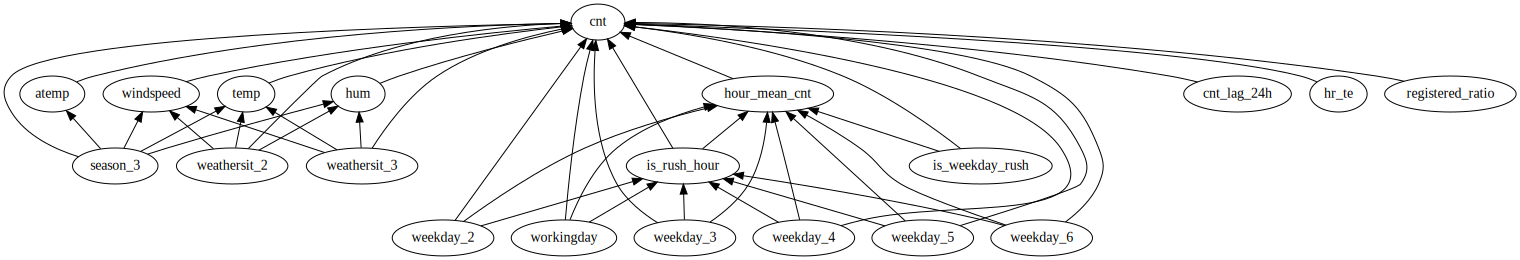

In [82]:
# Объект графа
causal_links = CausalLinks()

bool_cols = X_train_e.select_dtypes(include='bool').columns

X_train_e_clean = X_train_e.copy()
X_test_e_clean = X_test_e.copy()

for col in bool_cols:
    X_train_e_clean[col] = X_train_e_clean[col].astype(int)
    X_test_e_clean[col] = X_test_e_clean[col].astype(int)

# Добавляем влияние всех переменных на целевую
causal_links.add_causes_effects(list(X_train_e_clean.columns), # Переменные, которые влияют на целевую
                                'cnt', # Целевая переменная
                                create_xgboost_f(X_train_e_clean.columns, model) # Обёртка для модели, с помощью которой хотим предсказывать целевую переменную
                                )
causal_links.add_causes_effects(['season_3'], ['temp','atemp','hum','windspeed'])
causal_links.add_causes_effects(['weathersit_2','weathersit_3'], ['temp','hum','windspeed'])
causal_links.add_causes_effects(['workingday','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6'],
                                ['is_rush_hour','hour_mean_cnt'])
causal_links.add_causes_effects(['is_rush_hour','is_weekday_rush'], ['hour_mean_cnt'])
graph = build_feature_graph(X=X_test_e_clean, # Наши данные
                            causal_links=causal_links, # Описывает граф взаимосвязей
                            categorical_feature_names=set([c for c in X_train_e_clean.columns if c.startswith('weekday') or c.startswith('weathersit')]), # Названия категориальных переменных
                            target_name='cnt' # Название целевой переменной
                            )
graph.draw()

In [85]:
nruns = 100
bg = X_train_e_clean.sample(n=20, random_state=42).reset_index(drop=True)
fg = X_test_e_clean.sample(n=70, random_state=7).reset_index(drop=True)

In [86]:
# Получим интерпретации для выбранных примеров (для bg)
causal_edge_credits = [] # Контейнер для хранения результатов
for i in range(len(bg)): # Для каждого наблюдения, которое хотим интерпретировать
    cf_c = GraphExplainer(graph, bg[i:i+1], nruns=nruns).shap_values(fg) # Получим, на сколько коэффициенты Шепли наших наблюдений отличаются от выбранного семпла
    causal_edge_credits.append(node_dict2str_dict(cf_c.edge_credit)) # Складываем всё в историю, чтобы отрисовать на графе

bruteforce sampling: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


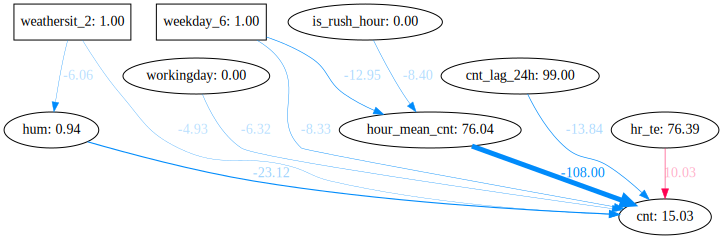

<AGraph <Swig Object of type 'Agraph_t *' at 0x7fed7cd90ea0>>

In [87]:
cf_c.draw(28, # Индекс наблюдения среди выбранных для интерпретации наблюдений
          max_display=10, # Сколько переменных отрисовывать
          show_fg_val=True, # Показывать ли значения переменных
          edge_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph) # Функция, чтобы правильно распарсить сохранённые результаты работы алгоритма
          )

на этом примере видно, что признаки weekday и is_rush_hour влияют на hour_mean_cnt. дейтсвительно, если сегодня суббота и сейчас не час пик, то hour_mean_cnt будет меньше.

#Итоговая модель

In [88]:
cat_params = dict(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    silent = True
)


baseline = CatBoostRegressor(**cat_params)

baseline.fit(X_train_e, y_train, eval_set=(X_test_e, y_test), early_stopping_rounds=50)
y_pred_base = baseline.predict(X_test_e)
print("Модель без SHAP")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_base)))
print("R2:", r2_score(y_test, y_pred_base))

explainer = shap.TreeExplainer(baseline)
shap_train = pd.DataFrame(explainer.shap_values(X_train_e), columns=X_train_e.columns, index=X_train_e.index)
shap_test = pd.DataFrame(explainer.shap_values(X_test_e), columns=X_test_e.columns, index=X_test_e.index)

model_emb = CatBoostRegressor(**cat_params)
model_emb.fit(shap_train, y_train, eval_set=(shap_test, y_test), early_stopping_rounds=50)
y_pred_emb = model_emb.predict(shap_test)
emb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_emb))
emb_r2 = r2_score(y_test, y_pred_emb)

print("Модель только на SHAP")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_emb)))
print("R2:", r2_score(y_test, y_pred_emb))

shap_train_renamed = shap_train.add_prefix('shap_')
shap_test_renamed = shap_test.add_prefix('shap_')

X_train_concat = pd.concat([X_train_e, shap_train_renamed], axis=1)
X_test_concat = pd.concat([X_test_e, shap_test_renamed], axis=1)
model_concat = CatBoostRegressor(**cat_params)
model_concat.fit(X_train_concat, y_train, eval_set=(X_test_concat, y_test), early_stopping_rounds=50)
y_pred_concat = model_concat.predict(X_test_concat)
concat_rmse = np.sqrt(mean_squared_error(y_test, y_pred_concat))
concat_r2 = r2_score(y_test, y_pred_concat)

print("Модель данные + SHAP")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_concat)))
print("R2:", r2_score(y_test, y_pred_concat))

Модель без SHAP
RMSE: 53.11695236954346
R2: 0.9108992901102779
Модель только на SHAP
RMSE: 53.04309385504014
R2: 0.911146904872974
Модель данные + SHAP
RMSE: 52.73501039666138
R2: 0.9121760556972709


In [ ]:
X_train_concat